# Tensorflow MPG Regression Example

This is a regression example.

In a regression problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the [classic Auto MPG Dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg) and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This is *not* using the Analytics Zoo -- instead it's using vanilla TF. However, we do have an [equivalent notebook for Zoo](./mpg-zoo.ipynb).


In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


/home/tfox/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tfox/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tfox/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tfox/anaconda3/lib/python3.7/site-packages/tensorboard/compat

# Get Data

Let's get the data. 

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/tfox/.keras/datasets/auto-mpg.data'

# Pandas

Import the dataset as a pandas dataframe.


In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Let's get rid of NA Values:


In [4]:
dataset.isna().sum() # Have a few NAs

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
dataset = dataset.dropna()
dataset.isna().sum() # Should have gotten rid of them now.

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

We should one-hot-encode the categorical 'Origin' variable

In [6]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Let's split the dataset between training and test.

In [7]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Pairplot of variables


Let's look at a Seaborn Pairplot of the variables. This shows us the relationship between our different variables.

Looking at this, you can see that (no surprise), there does appear to be a relationship between MPG and our varialbes of Cylinders, displacement, and weight. In all cases. the more cylinders/displacement/weight, the less MPG.

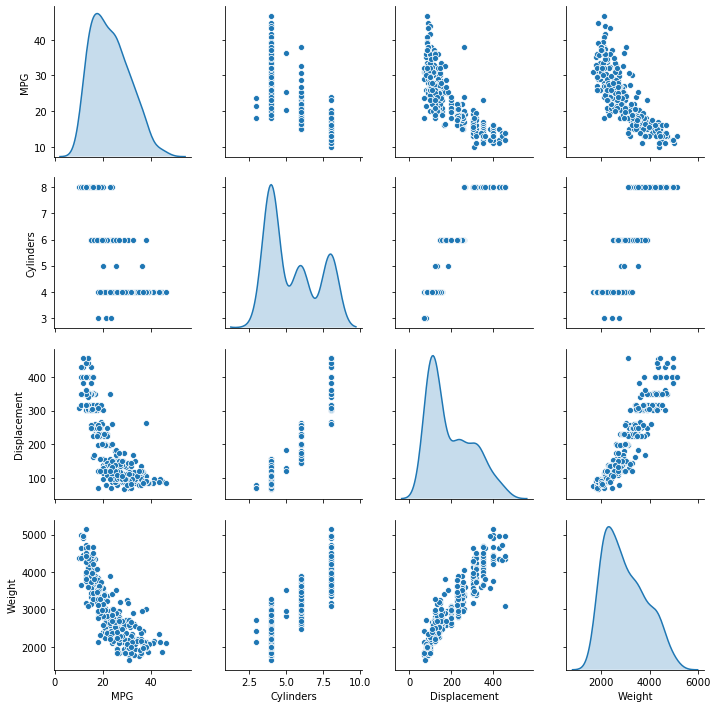

In [8]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

## Summary Statitics of variables

Let's look at some summary statistics of the variables.

In [9]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [10]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## Scaling

We should scale the variables.  What we do here is called Z-scoring, which means we mean-center (subtract by mean), and standardize by dividing by std.

In [11]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Build the Model

Let's build the model. This is going to be using Tensorflow (not Zoo's) Keras API.  

In [12]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [13]:
model = build_model()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [15]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.09549087],
       [ 0.13601716],
       [ 0.5830781 ],
       [-0.09611748],
       [ 0.31685114],
       [ 0.2679865 ],
       [ 0.3263677 ],
       [ 0.3074956 ],
       [ 0.23227616],
       [ 0.38107526]], dtype=float32)

In [16]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [17]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.956097,1.116197,2.956097,9.690569,2.327010,9.690569,995
996,2.974210,1.095962,2.974210,9.534350,2.281663,9.534350,996
997,2.995032,1.124665,2.995032,9.416401,2.364802,9.416401,997
998,3.019416,1.133429,3.019417,9.616810,2.334799,9.616810,998
999,2.950548,1.107762,2.950547,9.596471,2.343637,9.596471,999


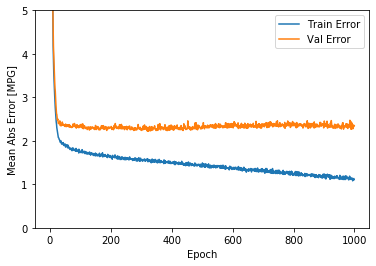

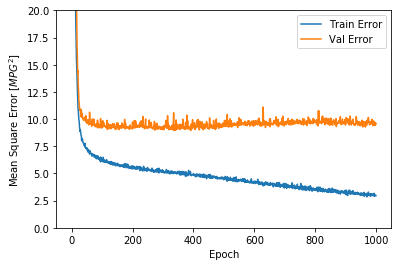

In [18]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


...............................................................

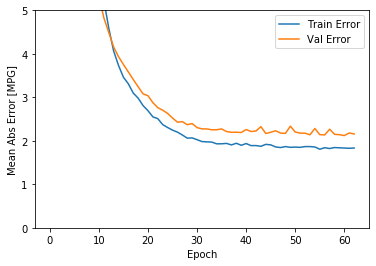

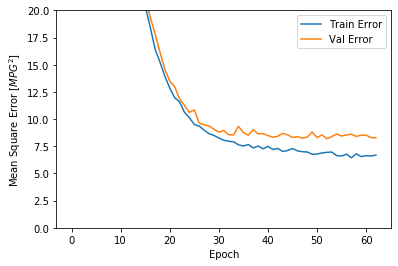

In [19]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [20]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.75 MPG


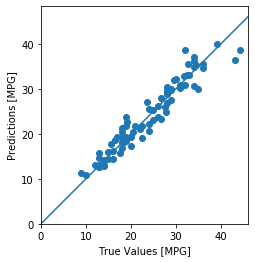

In [21]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

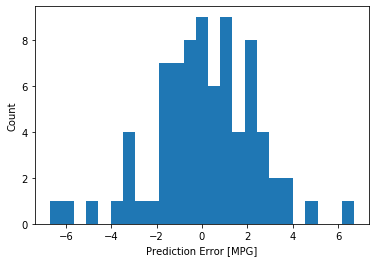

In [22]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [24]:
# Let's save the model
import os
te
mobilenet_save_path = os.path.join(tmpdir, "mpg/1/")
tf.saved_model.save(pretrained_model, mobilenet_save_path)

NameError: name 'tmpdir' is not defined